# TP 2.  Autour des forêts aléatoires



Dans ce TP, on rappelle brièvement quelques bases du machine learning, et on s'intéresse à un problème de régression avec des forêts aléatoires. Le notebook suit plus ou moins librement l'énoncé du TD 2 du cours disponible ici : http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/td2a_tree_selection_enonce.html#td2atreeselectionenoncerst  


## 1. Métriques d'évaluation en régression

Dans le TD précédent, on a vu les métriques d'évaluation pour les modèles de classification. Dans celui-ci, comme on s'intéresse à un problème de régression, on va d'abord voir quelques métriques classiques de régression. 

Supposons que l'on évalue ces métriques pour un ensemble $$(y_i, \hat{y}_i)_{i=1,...n_{\text{test}}}$$
avec $y_i$ l'output original, et $\hat{y_i}$ la prédiction du modèle. 

- **max-error** : L'erreur maximum est définie par $\text{ME} = \underset{i=1,...n_{\text{test}}}{\max} |y_i - \hat{y_i}|$. Cette erreur est rarement un bon indicateur des performances d'un modèle : elle est extrêmement sensible aux outliers. 
- **mean absolute error** :  elle est définie par $\text{ME} = \frac{1}{n_{\text{test}}} \sum_{i=1,...n_{\text{test}}} |y_i - \hat{y_i}|$. 
- **mean squared error** :  elle est définie par $\text{ME} = \frac{1}{n_{\text{test}}} \sum_{i=1,...n_{\text{test}}} (y_i - \hat{y_i})^2$. C'est une des mesures les plus utilisées. 

- **r2 score** : le r2 est défini par $$R^2 = 1 - \frac{\sum_{i=1,...n_{\text{test}}} (y_i - \hat{y_i})^2}{\sum_{i=1,...n_{\text{test}}} (y_i - \bar{y} )^2}$$, avec $\bar{y}$ moyenne des $y_i$. Le R2, contrairement aux mesures précédentes, est toujours entre 0 et 1, et permet des comparaisons plus larges. L'objectif est de rapprocher le R2 le plus possible de 1, contrairement aux métriques précédentes qu'il faut minimiser. 



## 2. Arbres de décisions

Dans ce TP, on s'intéresse aux arbres de décisions et aux forêts aléatoires, pour notre problème de régression. C'est l'un des modèles les plus simples en machine learning, mais il est important car il fait partie des rares modèles qui restent explicables : c'est le contraire du modèle boîte noire.


Un arbre de décision est un ensemble de règles de décision ordonnées, comme dans la figure ci-dessous. Il existe de nombreux types d'arbres de décision, mais en machine learning ils prennent souvent la forme d'arbre binaires. En parcourant l'arbre, on parcourt une succession de questions sur les variables de la base de données, jusqu'à déboucher sur une feuille, qui nous permet de savoir quel output attribuer à un input donné. 
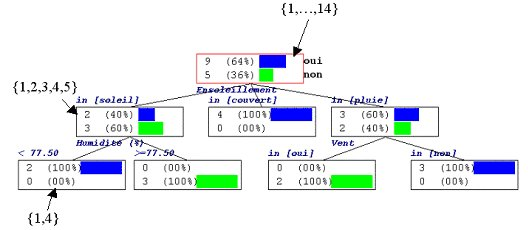

A ce stade, on peut se poser la question suivante : un arbre donné est facile à lire, mais sur quelles bases, sur quelles règles a-t-il été construit? 
Un algorithme classique de construction d'arbres est l'algorithme CART (Classification and Regression Trees). 

Pour formaliser un peu, on peut dire que dans cet algorithme, on suppose que l'arbre découpe l'espace des inputs en $M$ régions $R_1, ..., R_M$. La valeur attribuée en output pour un input $x$ peut être représenté sous la forme d'une fonction de décision $f$ telle que :
$$f(x) = \sum_{m=1, ..., M} c_m \times \mathbb{I}\left ( x \in R_m \right ) $$
Où les $c_m$ sont des constantes à déterminer lors de l'entraînement. On peut montrer que si le critère à minimiser est celui des moindres carrés, alors $$\hat{c_m} = \text{mean}(y_i|x_i in R_m) $$. 


Il nous reste à savoir comment obtenir le découpage de l'espace des inputs en $R_1, ..., R_m$. Pour cela, on procède de manière récursive : supposons que l'on ait choisi une variable $j\in\{1,..., p \}$ et un critère de split $s$. 
On définit :
$$R_1(j, s) = \{X|X_j \leq s\} $$
$$R_2(j, s) = \{X|X_j > s\} $$


Pour savoir quels sont les meilleurs $j, s$, on minimise les moindres carrés : 
$$\underset{j,s}{\min} \left ( \underset{c_1}{\min} \sum_{x_i \in R_1}  (y_i - c_1)^2     +  \underset{c_2}{\min}  \sum_{x_i \in R_2}  (y_i - c_2)^2    \right )$$

Avec ce programme d'optimisation, on peut facilement trouver notre variable et notre critère de split. Une seule question demeure alors : quand s'arrête-t-on de splitter nos régions? La profondeur de l'arbre est généralement considérée comme un hyperparamètre à optimiser. Les algorithmes classiques splittent donc de manière binaire jusqu'à ce que la taille de l'arbre atteignent ce paramètre (qu'on appellera dans la suite ```max_depth```), puis ensuite font du *pruning*, de l'élagage. L'élagage consiste à retirer certains noeuds de l'arbre, en fonction d'une fonction de coût-complexité qu'on ne détaillera pas ici. Si cela vous intéresse, vous pouvez lire le chapitre à ce sujet dans le Hastie (The Elements of Statistical Learning). 


Le problème principal des arbres de décision est leur grande variance : une erreur miniscule en haut de l'arbre est propagée tout au long de la descente dans l'arbre et elle empire vite. Pour stabiliser les prédictions de l'arbre, on préfère générer un ensemble d'arbres, une forêt. 




## 3. Forêts aléatoires


Pour créer une forêt aléatoire à $B$ arbres, on procède de la manière suivante :

- Pour $i$ allant de 1 à $B$ :
    - On tire aléatoirement avec remise un sous-échantillon des données taille $n<n_{\text{train}}$
    - On tire aléatoirement un sous échantillon des features de taille $m$ avec en général $m \leq \sqrt{p}$
    - Sur ce nouveau dataset composé de $n$ exemples et de $m$ features, on entraîne un arbre de décision de profondeur max fixée
- On obtient donc $B$ arbres de décision. Si l'on note $f_1, ..., f_B$ les fonctions de prédiction de chacun des arbres, alors en régression, la fonction de décision de la forêt $f_{RF}$ sera :
$$ f_{RF} (x) = \frac{1}{B} \sum_{i=1, ..., B} f_i(x)$$
En classification, les arbres votent et la classe la plus représentée est la classe choisie. 

On verra que cette aggrégation permet de rendre les prédictions beaucoup plus stables. 

## 4. Consignes pour ce TD :

1. Charger le dataset Boston de scikit-learn.
2. Entraîner un arbre de régression pour prédire la valeur immobilière, tracer l'arbre, et l'importance de chacune des features de la base. Evaluer avec la MSE et le R2, sur train et test.
3. Entraîner plusieurs arbres de régression en faisant varier le paramètre max_depth. Evaluer les performances avec la MSE et le R2, sur train et test, et tracer la courbe de ces métriques en fonction de max_depth. Que remarquez-vous? 
4. Entraîner plusieurs forêts aléatoires en faisant varier le paramètre max_depth. Evaluer les performances avec la MSE et le R2, sur train et test, et tracer la courbe de ces métriques en fonction de max_depth. Que remarquez-vous? 
5. Montrer que scikit-learn aggrège les prédictions de chaque arbre de la forêt en faisait la moyenne de celles-ci. 
6. Au lieu d'aggréger les arbres par la moyenne de leur prédictions, on veut apprendre sur X_train des coefficients pour pondérer les prédictions de chacun des arbres. Remplacer les features de la base par les prédictions de chacun des arbres, puis entraîner une régression linéaire. Représenter les valeurs des coefficients ainsi trouvés. Que remarquez-vous? 
7. Faire de même en remplaçant la régression linéaire par une régression LASSO. 

### 1. Charger le dataset Boston de scikit-learn.


In [1]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target

On va voir un peu quelles sont les variables dans le Boston dataset :

In [2]:
feat_names = data.feature_names

In [3]:
print(feat_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT - % lower status of the population

MEDV - Median value of owner-occupied homes in $1000's


In [7]:
print(X[0])
print(y[0])

[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00]
24.0


In [8]:
print(X.shape)
print(y.shape)

(506, 13)
(506,)


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)


## 1. Arbres de décision


Décrire les arbres

In [3]:
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error

In [93]:
reg = tree.DecisionTreeRegressor(max_depth=2)
reg = reg.fit(X_train, y_train)

In [94]:
y_pred = reg.predict(X_test)

In [95]:
mean_squared_error(y_pred, y_test)

28.854127315951974

In [96]:
r2_score(y_pred, y_test)

0.4245119343056869

[]

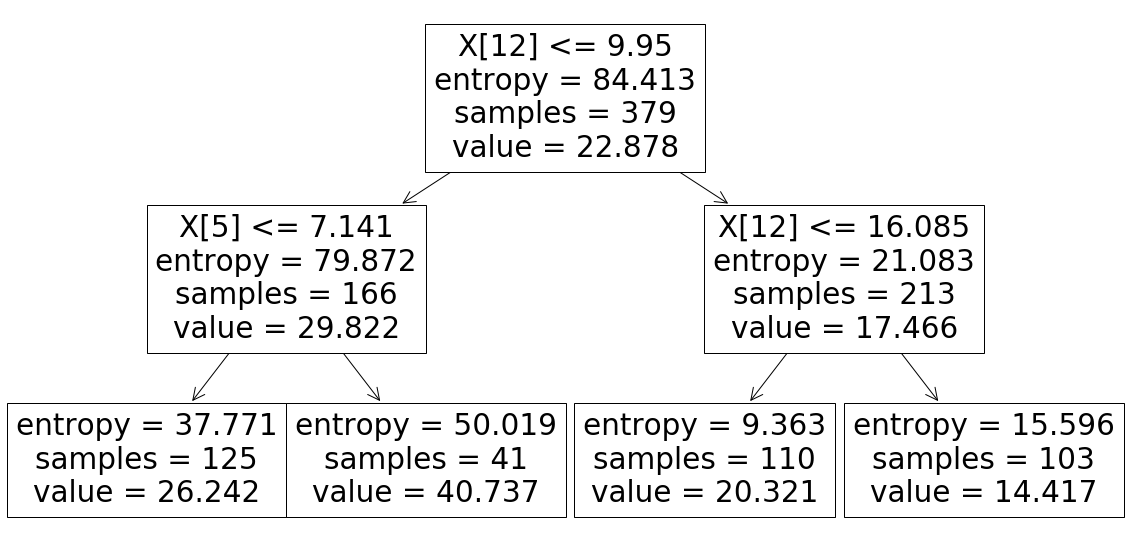

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(reg)
plt.plot()

In [45]:
X[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [49]:
reg.feature_importances_

array([2.30576155e-02, 7.25670093e-04, 7.62833596e-03, 1.20614209e-04,
       1.42767328e-02, 2.80934489e-01, 7.36150184e-03, 9.13824017e-02,
       2.47570390e-03, 1.17152940e-02, 2.68168841e-02, 9.27651773e-03,
       5.24228240e-01])

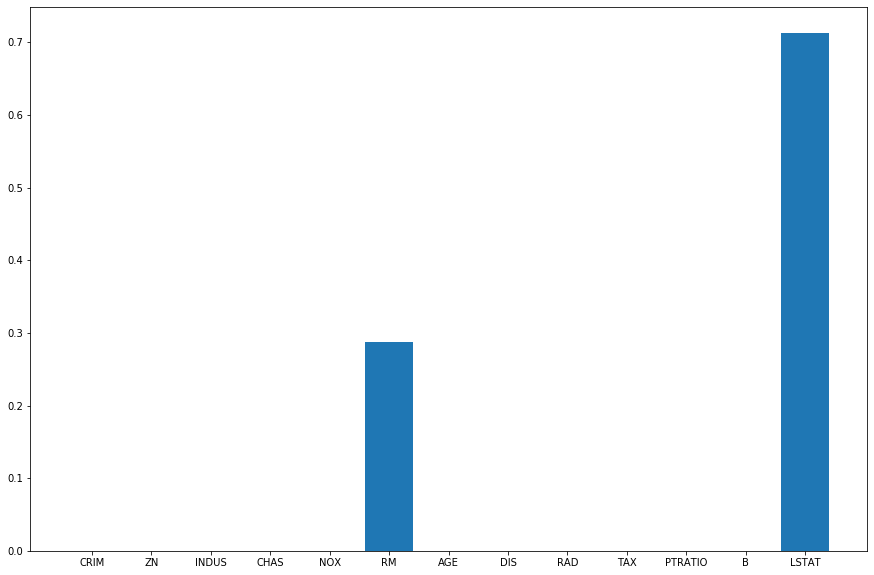

In [98]:
plt.figure(figsize=(15,10))
plt.bar([i for i in range(len(reg.feature_importances_))], reg.feature_importances_, tick_label=feat_names)
plt.show()

## 2. Influence de max_depth



In [83]:
max_depth_ls = [i for i in range(1,50)]
mse_train = []
mse_test = []
r2_train = []
r2_test = []

In [84]:
for m in max_depth_ls :
    reg = tree.DecisionTreeRegressor(max_depth=m)
    reg = reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred = reg.predict(X_test)
    mse_train.append(mean_squared_error(y_train, y_pred_train))
    mse_test.append(mean_squared_error(y_test, y_pred))
    r2_train.append(r2_score(y_train, y_pred_train))
    r2_test.append(r2_score(y_test, y_pred))

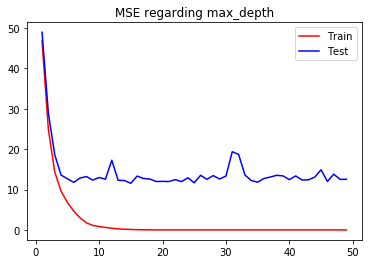

In [85]:
plt.figure()
plt.plot(max_depth_ls, mse_train, color='red', label='Train')
plt.plot(max_depth_ls, mse_test, color='blue', label='Test')
plt.title('MSE regarding max_depth')
plt.legend()
plt.show()


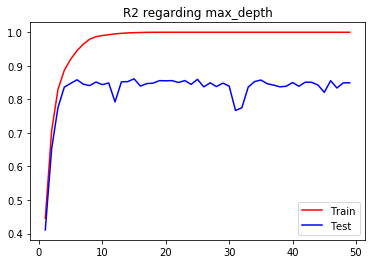

In [86]:
plt.figure()
plt.plot(max_depth_ls, r2_train, color='red', label='Train')
plt.plot(max_depth_ls, r2_test, color='blue', label='Test')
plt.title('R2 regarding max_depth')
plt.legend()
plt.show()

## 3. Random Forest

In [87]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=20, random_state=0,
                             n_estimators=100)
rf.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [88]:
print((mean_squared_error(y_test, rf.predict(X_test)), r2_score(y_test, rf.predict(X_test))))

(7.58297028895231, 0.9086675745985102)


In [89]:
max_depth_ls = [i for i in range(1,50)]
mse_train = []
mse_test = []
r2_train = []
r2_test = []


for m in max_depth_ls :
    rf = RandomForestRegressor(max_depth=m, random_state=0,
                                 n_estimators=100)    
    rf = rf.fit(X_train, y_train)
    y_pred_train = rf.predict(X_train)
    y_pred = rf.predict(X_test)
    mse_train.append(mean_squared_error(y_train, y_pred_train))
    mse_test.append(mean_squared_error(y_test, y_pred))
    r2_train.append(r2_score(y_train, y_pred_train))
    r2_test.append(r2_score(y_test, y_pred))

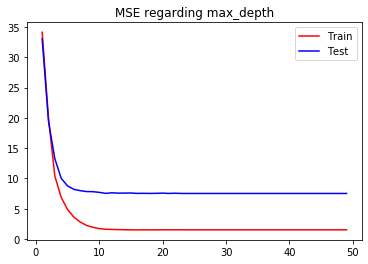

In [90]:
plt.figure()
plt.plot(max_depth_ls, mse_train, color='red', label='Train')
plt.plot(max_depth_ls, mse_test, color='blue', label='Test')
plt.title('MSE regarding max_depth')
plt.legend()
plt.show()

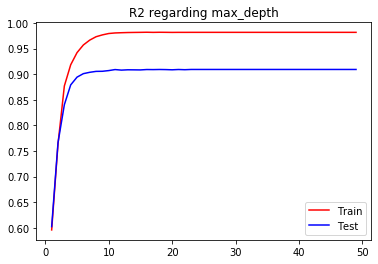

In [91]:
plt.figure()
plt.plot(max_depth_ls, r2_train, color='red', label='Train')
plt.plot(max_depth_ls, r2_test, color='blue', label='Test')
plt.title('R2 regarding max_depth')
plt.legend()
plt.show()

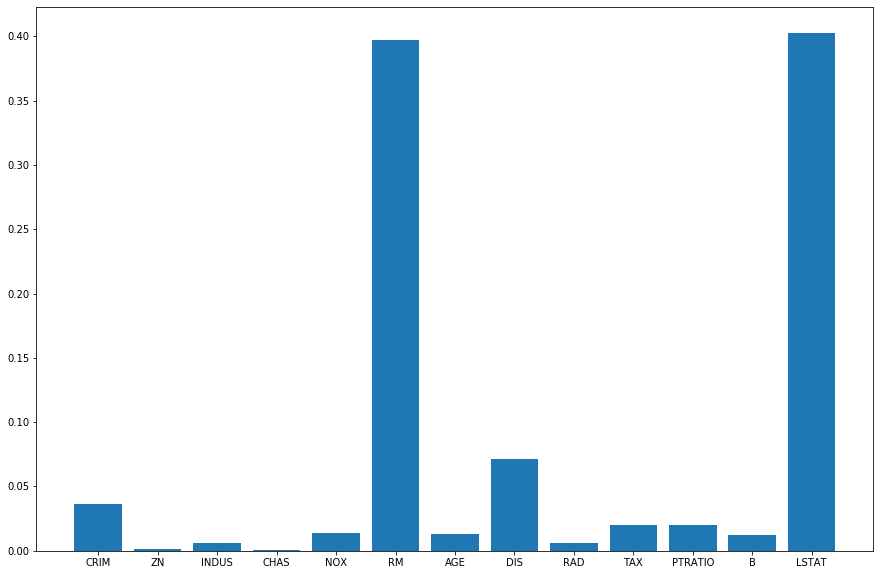

In [92]:
plt.figure(figsize=(15,10))
plt.bar([i for i in range(len(rf.feature_importances_))], rf.feature_importances_, tick_label=feat_names)
plt.show()

## 4. RF = moyenne des prédictions

In [106]:
import numpy


rf = RandomForestRegressor(max_depth=20, random_state=0,
                             n_estimators=100)    
rf = rf.fit(X_train, y_train)


# Pour récupérer chacun des arbres (déjà entraîné) : rf. estimator

dest = numpy.zeros((X_test.shape[0], len(rf.estimators_)))
estimators = numpy.array(rf.estimators_).ravel()
for i, est in enumerate(estimators):
    pred = est.predict(X_test)
    dest[:, i] = pred

average = numpy.mean(dest, axis=1)
r2_score(y_test, average)

0.9086675745985102

In [107]:
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)

0.9086675745985102

## 5. Regréssion linéaire sur la random forest


Idée : aggréger les arbres par la moyenne donne le même poids à chacun des arbres, qu'ils soit bon ou pas. On peut essayer d'améliorer ça en trouvant des poids adaptés à chacun des arbres. 

-> on fait une régression linéaire pour trouver ces coefficients de pondération. 



In [108]:


def new_features(forest, X): 
    dest = numpy.zeros((X.shape[0], len(forest.estimators_)))
    estimators = numpy.array(forest.estimators_).ravel()  # On récupère les arbres 
    for i, est in enumerate(estimators):  # On itère : pour l'arbre i :
        pred = est.predict(X)  # L'arbre i prédit sur X 
        dest[:, i] = pred  # La nouvelle feature i est définie comme la prédiction de i sur X 
    return dest



In [110]:
# Création de la nouvelle base : 
X_train2, X_test2 = new_features(rf, X_train), new_features(rf, X_test)

In [111]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train2, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

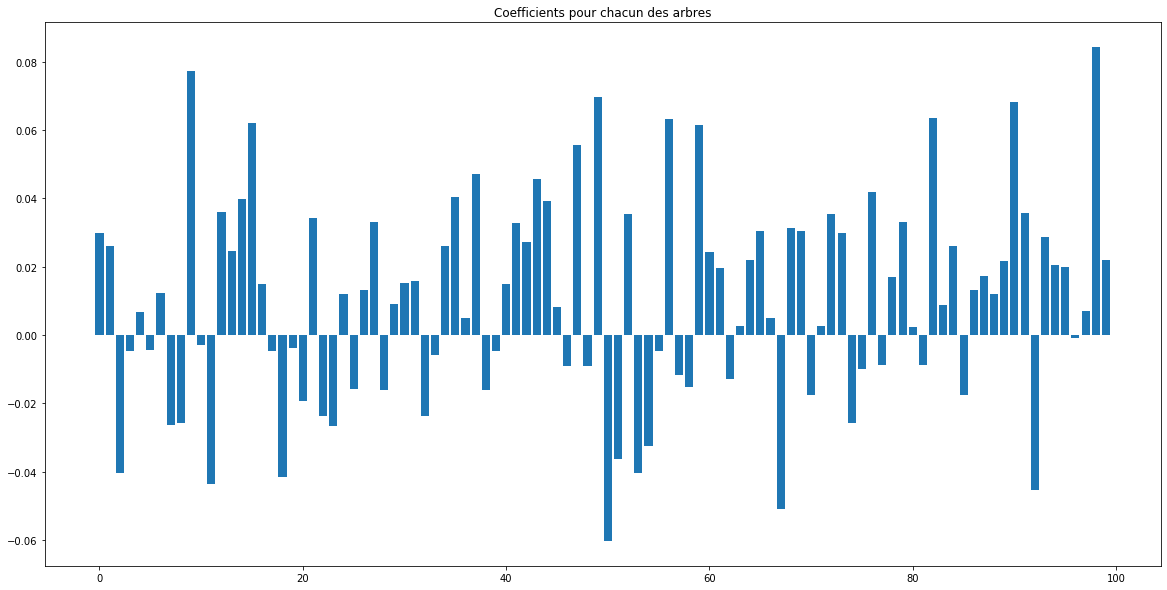

In [112]:
# On printe les coeffs : 
plt.figure(figsize = (20,10))
plt.bar([i for i in range(len(rf.estimators_))], lr.coef_)
plt.title('Coefficients pour chacun des arbres')
plt.show()

In [113]:
y_pred = lr.predict(X_test2)
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

9.272951854297517
0.8883127387801955


Performances < aggrégation par la moyenne!

## 6. Lasso


Dans le lasso, on borne la norme L1 du vecteur des coeffs : 
$$ \underset{||\beta||_1<\alpha}{min} \frac{1}{N} \sum_{i=1}^N (y_i - xi^T \beta)^2 $$
Avec 
$$||\beta||_1 = \sum_{j=1}^p |\beta_j|$$


C'est une régression linéaire pénalisée. Certaines coordonnées de $\beta$ vont être égales à 0 : c'est notre séléction de variables

Le LASSO permet de séléctionner les variables.

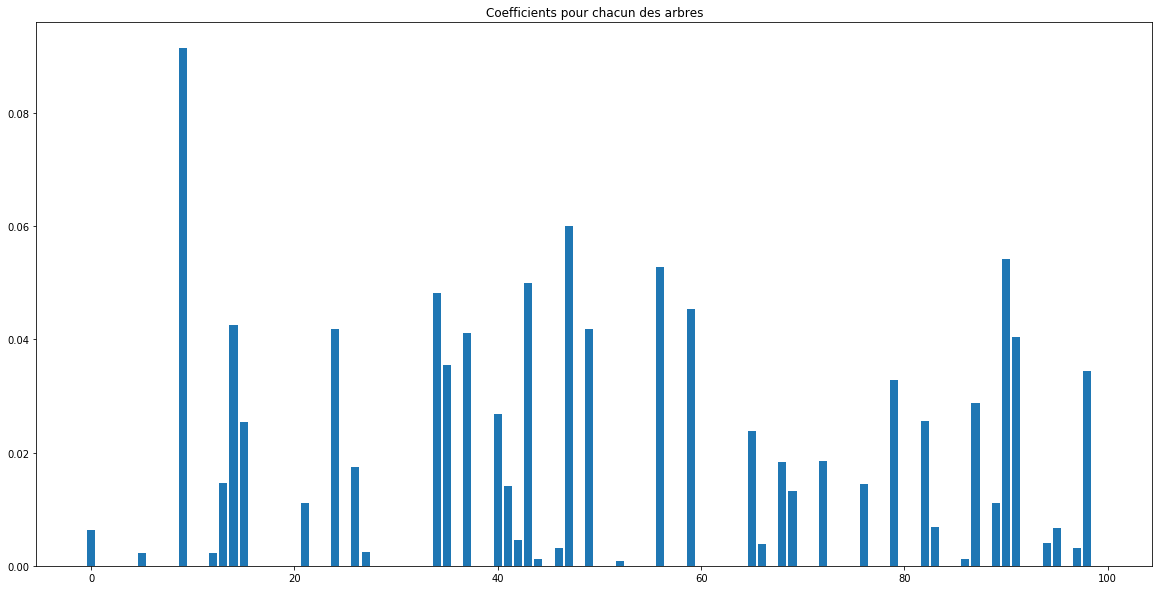

In [116]:
from sklearn.linear_model import Lasso
lr_pen = Lasso(max_iter=100000)
lr_pen.fit(X_train2, y_train)


# On printe les coeffs : 
plt.figure(figsize = (20,10))
plt.bar([i for i in range(len(rf.estimators_))], lr_pen.coef_)
plt.title('Coefficients pour chacun des arbres')
plt.show()

In [117]:
y_pred = lr_pen.predict(X_test2)
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

7.779323564457457
0.9063026146680278


C'est mieux, mais toujours moins bien que la moyenne. 

$\alpha$ est un hyperparamètre que l'on peut tester : on va plotter la MSE et le R2 en fonction de $\alpha$.

In [118]:
from tqdm import tqdm #Package qui permet de faire de jolies barres de progression et d'estimer le temps total d'une boucle for


alphas = [0.01 * i for i in range(100)] +[1 + 0.1 * i for i in range(100)]
mse_train = []
mse_test = []
r2_train = []
r2_test = []
for i in tqdm(range(0, len(alphas))):
    alpha = alphas[i]
    lrs = Lasso(max_iter=20000, alpha=alpha)
    lrs.fit(X_train2, y_train)
    mse_train.append(mean_squared_error(y_train, lrs.predict(X_train2)))
    mse_test.append(mean_squared_error(y_test, lrs.predict(X_test2)))
    r2_train.append(r2_score(y_train, lrs.predict(X_train2)))
    r2_test.append(r2_score(y_test, lrs.predict(X_test2)))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]L:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if sys.path[0] == '':
L:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
L:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140.19264724320095, tolerance: 3.199249936675462
  positive)
  0%|▍                                                                                 | 1/200 [00:00<02:24,  1.37it/s]L:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_des

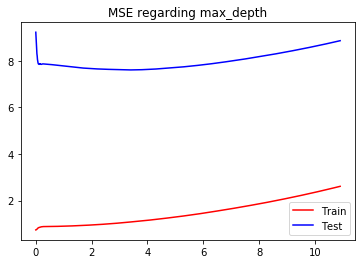

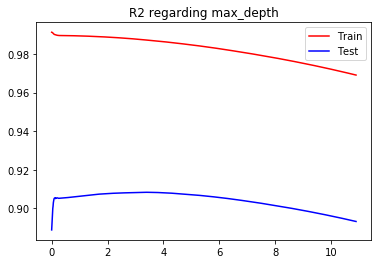

In [120]:
plt.figure()
plt.plot(alphas, mse_train, color='red', label='Train')
plt.plot(alphas, mse_test, color='blue', label='Test')
plt.title('MSE regarding max_depth')
plt.legend()
plt.show()

plt.figure()
plt.plot(alphas, r2_train, color='red', label='Train')
plt.plot(alphas, r2_test, color='blue', label='Test')
plt.title('R2 regarding max_depth')
plt.legend()
plt.show()